# Experiment Tracking and Model Management for Flipkart sentiment analysis using MLFlow

![mlflow](mlflow.png)

### Background

Flipkart is an Indian e-commerce company focused on online book sales, consumer electronics, fashion, home essentials, groceries, and lifestyle products. A team of Data Engineers has scraped real-time data from the Flipkart website. This data  consists of 8,518 reviews for the "YONEX MAVIS 350 Nylon Shuttle" product from Flipkart. Each review includes features such as Reviewer Name, Rating, Review Title, Review Text, Place of Review, Date of Review, Up Votes, and Down Votes.


The objective of this task is as follows:

- Find the best possible model to classify user reviews as either positive or negative
- Utilize MLflow for experiment tracking, model management, and reproducibility of this machine learning project for the sentiment analysis
- Orchestrate the the pipeline or machine learning workflow created


**P.S: This project is an extension of the sentiment analysis project I carried out earlier. This project is focused mainly on the integration and use of mlflow and prefect for:** 

- Experiment tracking
- Model management
- Orchestration

## Loading the data

In [143]:
# importing library and reading csv file

import pandas as pd
product_review = pd.read_csv('Nylon Shuttle.csv')

product_review.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


## Step 1: Exploratory Data Analysis

This is essential for understanding the data, detecting patterns and anomalies, revealing data inconsistencies and feature selection, etc.

In [144]:
product_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [145]:
product_review.isna().sum().sort_values(ascending = False)

#the number of null values for each column in the data

Month              465
Place of Review     50
Reviewer Name       10
Review Title        10
Up Votes            10
Down Votes          10
Review text          8
Ratings              0
dtype: int64

In [146]:
product_review.describe()

#relevant statistics on the numerical columns in the data

,Up Votes,Down Votes,Ratings
count,8508.000000,8508.000000,8518.000000
mean,0.391396,0.121768,4.181028
std,11.613909,3.248022,1.262200
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,4.000000
50%,0.000000,0.000000,5.000000
75%,0.000000,0.000000,5.000000
max,889.000000,219.000000,5.000000


### Feature selection

Refers to selecting revelant columns for our machine learning algorithm to train and learn from. 

The objective here is to classify a user's review as either positive, or negative. To that effect the following columns are of relevance:

- Review Text
- Ratings (from which the Label column will be created)

1. First, we add a new feature by creating a 'Label' column based on the ratings column which would serve as our output or target variable for the ML model


2. Second, we create a new dataframe containing only the columns of interest - Review text and Label


3. We drop the observed 8 null values in the Review Text column. In this case we drop them since they are few in number to prevent the ML alogirthm from being wrongly influenced. 

In [147]:
# 1. Create a new feature called label

product_review.loc[:,'Label'] = product_review['Ratings'].apply(lambda x: 'Negative' if x <= 3 else 'Positive')
product_review.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,Label
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,Positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,Negative
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,Negative
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Negative


In [148]:
product_review.shape

(8518, 9)

In [149]:
# 2. Creating a new dataframe

reviews = product_review[['Review text', 'Label']]
reviews.head()

,Review text,Label
0,"Nice product, good quality, but price is now r...",Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,Negative
2,Worst product. Damaged shuttlecocks packed in ...,Negative
3,"Quite O. K. , but nowadays the quality of the...",Negative
4,Over pricedJust â?¹620 ..from retailer.I didn'...,Negative


In [150]:
# 3. Dropping the rows of data containing null values in the Review text column

reviews.dropna(subset=['Review text'], inplace=True)
reviews.isna().sum().sort_values(ascending = False)

Review text    0
Label          0
dtype: int64

In [151]:
#to see the shape of the dataframe
reviews.shape

(8510, 2)

In [152]:
#to identify outliers
#a view of the first 20 elements of the data


reviews['Review text'].head(20)

0     Nice product, good quality, but price is now r...
1     They didn't supplied Yonex Mavis 350. Outside ...
2     Worst product. Damaged shuttlecocks packed in ...
3     Quite O. K. , but nowadays  the quality of the...
4     Over pricedJust â?¹620 ..from retailer.I didn'...
5     Good quality product. Delivered on time.READ MORE
6     BEST PURCHASE It is a good quality and is more...
7              Good quality original shuttles.READ MORE
8                                      AwesomeREAD MORE
9                       nice original productsREAD MORE
10    This GREEN CAP SHUTTLECOCK is really AWESOME. ...
11                           Best in class....READ MORE
12    it's genuine and price is less than our near b...
13    This is the second time i am getting an opened...
14    really satisfied with the quality and the prom...
15                                         NycREAD MORE
16    I usually buy them the same model but this did...
17                  Poor quality, not originalRE

'READ MORE' is an outlier here and hence will be removed later on in the data preprocessing step. For more context, 'READ MORE' in terms of a user's review represents hyperlinks that a viewer clicks on to see the remaining part of a customers review.

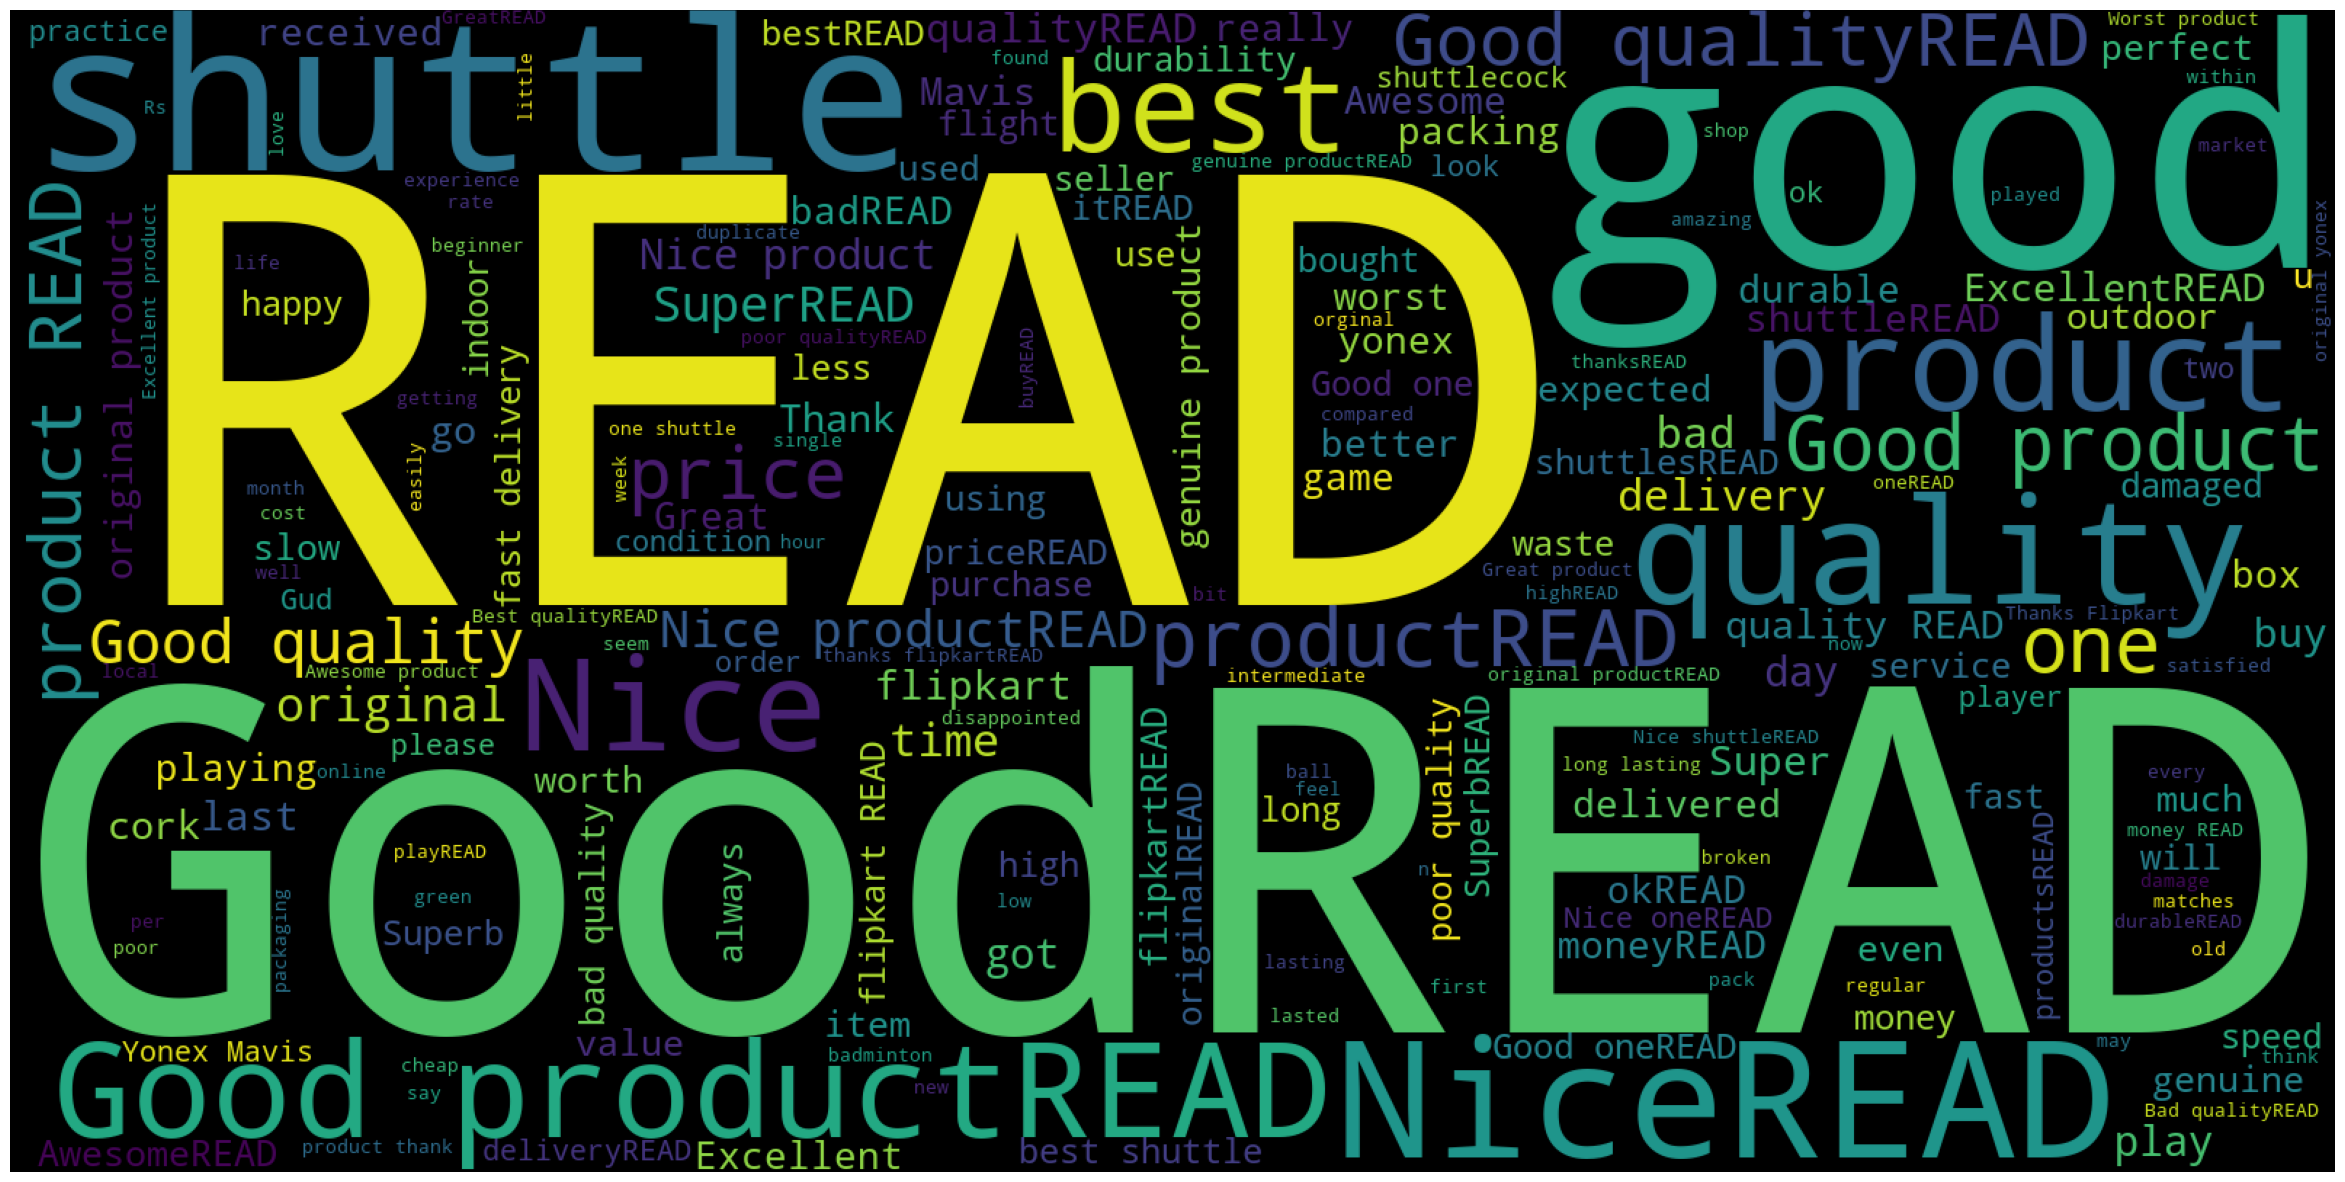

In [153]:
#let's have a visual representation of our review data

import matplotlib.pyplot as plt
import seaborn as sns

# visualizing an overall word cloud from the data

# converting any digits found to strings
reviews['Review text'] = reviews['Review text'].astype(str)

from wordcloud import WordCloud

wc = WordCloud(background_color = 'black',
              width=1600,
              height=800).generate(' '.join(reviews['Review text']))

plt.figure(1, figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

Positive    0.801763
Negative    0.198237
Name: Label, dtype: float64


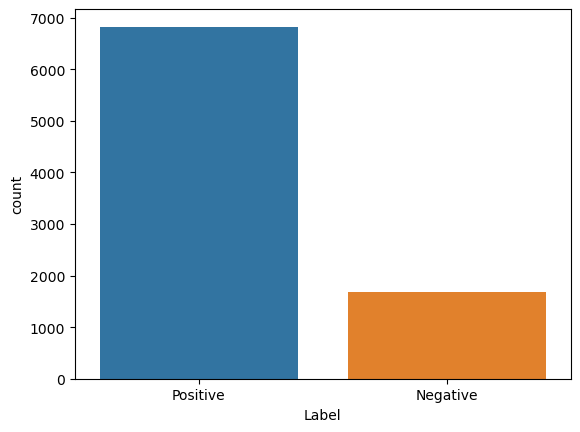

In [154]:
# what is the distribution of our target variable like?

print(reviews['Label'].value_counts(normalize=True))

sns.countplot(x='Label', data = reviews)
plt.show()

This highlights a potential issue of data imbalance as we have more than half the data as Positive reviews which leaves a mearge 19% available data on negative reviews.That is, most of the reviews were positive reviews which makes sense in a real world scenario as a product can have so many positive reviews and a few negative reviews alongside it.

## Step 2: Identify the input(X) and output(y)

In [155]:
#renaming the Review text column
reviews = reviews.rename(columns={'Review text': 'Review_text'})

X = reviews['Review_text'] #this column contains text data to extract reviews from 
y = reviews['Label'] #this is the column the ml algorithm will learn to predict

print(X.shape, y.shape)

(8510,) (8510,)


In [156]:
reviews.head()

,Review_text,Label
0,"Nice product, good quality, but price is now r...",Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,Negative
2,Worst product. Damaged shuttlecocks packed in ...,Negative
3,"Quite O. K. , but nowadays the quality of the...",Negative
4,Over pricedJust â?¹620 ..from retailer.I didn'...,Negative


## Step 3: Data Preparation - Split the data into train and test set

In [157]:
# splitting into train and test

from sklearn.model_selection import train_test_split

#splitting the data into 80% train data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)

#random_state is used to ensure that the data splitting process is reproducible. 
#that is, no matter how many times the code is run, you will get the same split of data each time

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6808,) (1702,)
(6808,) (1702,)


## Step 4: Data preprocessing on train data(X_train)

In [158]:
# importing libaries

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [159]:
#intializing the lemmatizer object
lemmatizer = WordNetLemmatizer()

In [132]:
#defining a function for data cleaning

def clean(doc): # doc is a string of text
    
    # removing outlier strings
    doc = doc.replace("READ MORE", " ")
    
    # Remove punctuation and numbers.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [160]:
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

#the numerical feature extraction method performed here is Bag of Words represneted by CountVectorizer in sklearn

# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_num = vect.fit_transform(X_train)

print(X_train_num.shape)

Wall time: 4.12 s
(6808, 2541)


It is important to note the following:

- fit: means to train on or learn from the data
- transform: means to preprocess the data
- fit_transform: this means to preprocess then train on the data

Why is this important?

This is because:

- fit is used to build the model, 


- transform is used on test data for data preprocessing, and


- fit_transform is used on train data for data preprocessing and learning

Perchance you use fit_transform for both test and train data you will end up with a case of data leakage where the model being built has been exposed to unseen data beforehand and will therefore lead to cases of overfitting The model is meant to be built in such a way that it has no exact idea what the test data will look like. 

## Step 5: Data preprocessing on test data(X_test)

In [161]:
# transform testing data (using training data's features)
X_test_num = vect.transform(X_test)

print(X_test_num.shape)

(1702, 2541)


At this point we've carried out an EDA, data splitting and data preprocessing. The next step is to train our model. Many algorithms exists to make this training effective and provide the best results. Since we're dealing with a classification problem, we know we could use either KNN, Decision tree, random forest, Support Vector classifier(SVC), Naive Bayes, etc. But then how do we find the best possible model from any of these algorithms if there are dozens of algorithm parameters that can be tweaked to turn in the best possible model for this task.

This is where the concept of **building a pipleine for optimal workflow** comes in. A pipeline allows us the opportunity to sequentially apply a list of machine learning algorithms to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling. It is important because it is:

- Efficient for hyper parameter tuning and cross-validation for machine learning algorithms

- Aids ML Workflow automation

So what do we do? Build a pipeline!!  

**But wait, there's more.** I see a potential issue upfront. What is it?

Let's say we have been able to obtain the best parameter configuration that produced the best model so far. 

- What happens then when we want to explore and experiment further based on these parameters to get an even better model than the previous one? 


- What happens when we keep changing and modifying these parameters? And then boom, we find that the parameters at the second iteration or even the first was the best we could have asked for and all the other ones we have tried so far turned out badly.


- How do we retrace our steps to the point where we started especially in a case where we have no clue the parameters we used at the very beginning.


This is where **experiment tracking and model management shines through**. To implement this here, the pipleine which we will build will be created after setting up our expeiment tracking tool in this case **MLFLow**.

Mflow helps to organize our experiments into runs. It keeps track of:

- Tags
- Parameters
- Metrics
- Models
- Artifact, etc.

## Step 6: Experiment tracking and pipleine building

### a. Running the experiment

In [162]:
#importing libraries

#library for generating pipleines
from sklearn.pipeline import Pipeline

#machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

#for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

In [163]:
#to manage and suppress warnings

import warnings
warnings.filterwarnings('ignore')

### b. Setting up mlflow

On your command prompt:

- Step 1: Head over to the command prompt on your local device, create a virtual environment and activate it
- Step 2: Install mlflow
- Step 3: pip install setuptools --upgrade
- Step 3: Launch mlflow ui, copy and paste the url in your browser


In your jupyter notebook:

In [164]:
#import mlflow and set experiment name

import mlflow
mlflow.set_experiment('Flipkart Sentiment Classifer')

2024/03/28 08:21:06 INFO mlflow.tracking.fluent: Experiment with name 'Flipkart Sentiment Classifer' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/USER/mlruns/821144614845982293', creation_time=1711610466900, experiment_id='821144614845982293', last_update_time=1711610466900, lifecycle_stage='active', name='Flipkart Sentiment Classifer', tags={}>

### c. Autologging all experiment runs using mlflow

- Step 1: Define the pipeline steps (i.e, a list of all the algorithms to be used)
- Step 2: Defining the paramter grid for each algorithm (i.e, the configurations - hyper parameters - required for each algorithm)
- Step 3: Run the pipeline and autolog the experiment runs with mlflow (i.e, performing GridSearchCV for each algorithm)
    

In [165]:
#Step 1

#first, caching to optimize runtime
import joblib
from joblib import Memory
import os


#Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)


pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ],
    memory = memory)
    
}

In [166]:
#Step 2

param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features': [1000, 1500, 2000, 2500],
            'classifier__alpha': [1,10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features': [1000, 1500, 2000, 2500],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features': [1000, 1500, 2000, 2500],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['elasticnet'],
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight':['balanced']
        }
    ]
}

In [167]:
#Step 3

best_models ={}

#running the pipeline
for algo in pipelines.keys():
    print('*' * 10, algo, '*' * 10)
    grid_search = GridSearchCV(estimator = pipelines[algo],
                              param_grid = param_grids[algo],
                              cv = 5,
                              scoring = 'accuracy',
                              return_train_score = True,
                              verbose = 1
                              )
    
    mlflow.sklearn.autolog(max_tuning_runs=None)
    
    with mlflow.start_run() as run:
        %time grid_search.fit(X_train, y_train)
        
    print('Train Score: ', grid_search.best_score_)
    print('Test Score: ', grid_search.score(X_test, y_test))
    
    best_models[algo] = grid_search.best_estimator_
    print()

2024/03/28 08:21:18 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 15.8 s
Train Score:  0.8826416828776458
Test Score:  0.8913043478260869

********** decision_tree **********


2024/03/28 08:21:34 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Wall time: 20.5 s
Train Score:  0.8879274870231247
Test Score:  0.8860164512338425

********** logistic_regression **********


2024/03/28 08:21:55 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 8min 49s
Train Score:  0.9004139868650611
Test Score:  0.900117508813161



Experiment logging completed!!


The next step is to head over to the Mlflow interface for model mangaement and further steps.


- First, rename the Run Name based on the the type of algorithm used, e.g LogisticRegression_run
- Next, manage the artifacts by registering the best estimator from all the models for each algorithm
- Explore the metrics to compare the models
- In the model registry, move your choice model in this case naive bayes - version 3 into production